In [14]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline
%load_ext watermark
%watermark

Last updated: 2022-02-15T15:37:49.245158+01:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 8 Stepping 2, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



# Plan

1. Description of trapped ions.
2. Simulation in 1D with velocity-Verlet.
3. Simulation in 1D with Runge-Kutta fourth-order
    1. (first method)
    2. (second method)
4. Other references.

# 1. Trapped ions physics

In 1D the motion equation of a trapped ion $i$, in an RF field, with friction and Coulomb interaction is as follows :

$m\ddot y_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma\dot y_i$

Numerically solve this equation is equivalent to obtain the set of variables $y_i$, $v_i=\frac{\mathrm{d}y_i}{\mathrm{d}t}$ and $a_i = \frac{\mathrm{d^2}y_i}{\mathrm{d}t^2}$ that fulfill this equation. Several methods can be used. In our Fortran code, when there are no friction velocity-Verlet method (VV) is used, but when friction is implemented another method must be used. Blümel *et al* use Runge-Kutta fourth order method (RK4). This document deals with both VV and RK4.

For RK4 it is convenient to write the second order differential equation as a system of two first order differential equations

$\dot y_i = v_i \\ \dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$

It may seems that this decomposition is artificial, expecially because there is no analytical expression for the velocity $v_i$. Nevertheless this is no problem because the actual value for the velocity $v_i$ is know at the beginning of each step of RK4 algorithm.

# 2. Simulation of a trapped ion

In [15]:
# definition of physical variables
C_e = 1.602e-19
m_Ca = 40.078*1.66054e-27 # mass of trapped ion
r0 = 2.5e-3    # trap internal radius
Omega = 2*np.pi*2e6  # RF field angular frequency
Urf = 40       # RF voltage amplitude

### With velocity-Verlet
Velocity-Verlet method is used as reference

In [16]:
# velocity-verlet for the trapped ion
class velocity_verlet:
    def update_position(x,v,a1_vv): # return x
        return x + v*dt_vv + 0.5*a1_vv*dt_vv**2
    def update_acceleration(x,t): # return a2
        return 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x
    def update_velocity(v,a1_vv,a2_vv): # return v
        return v + 0.5*(a1_vv+a2_vv)*dt_vv

# variables simu
dt_vv = 2*np.pi/(100*Omega) # s
nper = 50

t_vv = np.arange(0,nper*100*dt_vv,dt_vv)
x_vv,v_vv,a1_vv = [[],[],[]]

# initialisation
x_vv.append(r0/4)
a1_vv.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
a2_vv = []
b.append(0)

# VV algorithm

for time in t_vv[:-1]:
    x_vv.append( velocity_verlet.update_position(x_vv[-1],v_vv[-1],a1_vv[-1]) )
    a2_vv.append( velocity_verlet.update_acceleration(x_vv[-1],time) )
    v_vv.append( velocity_verlet.update_velocity(v_vv[-1],a1_vv[-1],a2_vv[-1]) )
    a1_vv.append(a2_vv[-1])

### 3. Runge-Kutta fourth-order method

##### Runge-Kutta of order 4 (RK4)

$y_i(t_n)$ is the value of the quantity $y_i$ at time $t_n$. The RK4 algorithm estimates the value of the same quantity $y_i$ at the next simulation step $t_{n+1}$ using two intermediate estimate values at midpoint and one estimate value at endpoint. The time step $h$ is defined so that $t_{n+1}-t_n=h$. RK4 proceeds in 4 steps where everytime it estimates the slope of the value in different conditions :
1. Estimates the derivative (slope) $k_1$ at initial point. This allows to compute a first approximation of $y_i(t_{n+1})$.
2. Estimates the derivative (slope) $k_2$ at midpoint using $k_1$.
3. Estimates the derivative (slope) $k_3$ at midpoint using $k_2$.
4. Estimates the derivative (slope) $k_4$ at midpoint using $k_3$.

$k_j$ is the slope of the function at step $j$. Then a ponderate average is computed so that the variable value at endpoint is

$x_{n+1} = x_n + \frac{1}{6}(k_1+2k_2+2k_3+k_4)$ with
$k_1 = hf(t_n,x_i(t_n)) \\
k_2 = hf(t_n+h/2,x_i(t_n)+k_1/2) \\
k_3 = hf(t_n+h/2,x_i(t_n)+k_2/2) \\
k_4 = hf(t_n+h,x_i(t_n)+k_3) $

$f$ is an arbitrary function computing the derivate according to one of the first-order ODE above mentionned.

##### For our specific problem
In the case treated here, the motion equation mentionned above is a second-order differential equation. It requires to split it into two first-order differential equations.

$\dot y_i = v_i \\ \dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$

Then it is possible to use RK4 to compute each variables $y$ and its derivative $\mathrm{d}y/\mathrm{d}t$. At each step $t_n$ it is only required to know $v_i(t_n)$ in order to compute the next step, and this value is already known either from initialisation of from previous RK4 step. So this first equation $\dot y_i = v_i$ do not require any analytical expression at all. This is used just below with the first RK4 method, but is also used in the second case in a much more direct way.

### 3.A As in [this wiki](https://fr.wikipedia.org/wiki/Méthodes_de_Runge-Kutta#La_méthode_de_Runge-Kutta_d'ordre_quatre_avec_dérivée_seconde)

Here only $\dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$ is used.

In [101]:
# Runge-Kutta fourth order (RK4)
# for the trapped ion
class runge_kutta_4:
    def dv_dt(x,v,t):
        return 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x - gamma/m_Ca*v
    def dx_dt(x,a):
        return 1/gamma * ( m_Ca * a - 2*C_e*Urf/(r0**2)*np.cos(Omega*t)*x )
    def update_slopes(x,v,t,h):
        k1 = runge_kutta_4.dv_dt(x,v,t)
        k2 = runge_kutta_4.dv_dt(x+h/2*v,v+h/2*k1,t+h/2)
        k3 = runge_kutta_4.dv_dt(x+h/2*v+h**2/4*k1,v+h/2*k2,t+h/2)
        k4 = runge_kutta_4.dv_dt(x+h*v+h**2/2*k2,v+h*k3,t+h)
        return k1, k2, k3, k4
    def update_pos_vel(x,v,h,k1,k2,k3,k4):
        x = x + h*v + h**2/6*(k1+k2+k3)
        v = v + h/6*(k1+2*k2+2*k3+k4)
        return x,v

In [103]:
# variables simu
nt = 100
dt_rk4 = 2*np.pi/(nt*Omega) # s
h = dt_rk4
gamma = 1e-20

t_rk4 = np.arange(0,nper*nt*dt_rk4,dt_rk4)
x_rk4,v_rk4,a1_rk4 = [[],[],[]]

# initialisation
x_rk4.append(r0/4)
a1_rk4.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
v_rk4.append(0)

# RK4 algorithm

for time in t_rk4[:-1]:
    k1,k2,k3,k4 =  runge_kutta_4.update_slopes(x_rk4[-1],v_rk4[-1],time,h)
    x_rk4 .append( runge_kutta_4.update_pos_vel(x_rk4[-1],v_rk4[-1],h,k1,k2,k3,k4)[0] )
    v_rk4 .append( runge_kutta_4.update_pos_vel(x_rk4[-1],v_rk4[-1],h,k1,k2,k3,k4)[1] )
    a1_rk4.append( runge_kutta_4.dv_dt(x_rk4[-1],v_rk4[-1],time) )

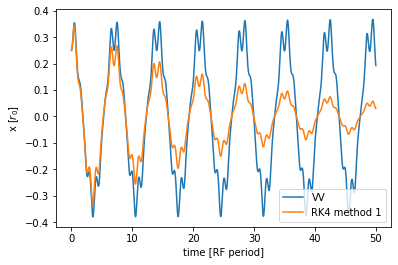

In [45]:
plt.figure('Ion algorithm',clear='True')
ax = plt.subplot(111)

ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt),v_vv,color='g',ls='--',label='VV')
# ax.plot(t_vv/(100*dt),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,label='RK4 method 1')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,label='RK4')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()

### 3.B With Runge-Kutta as in this [Stack exchange](https://math.stackexchange.com/questions/721076/help-with-using-the-runge-kutta-4th-order-method-on-a-system-of-2-first-order-od) (but I have seen this elsewhere)

Here the dynamic variables $y_i$ and $v_i$ are grouped into a single array $Y = [y_i, v_i]$. $a_i$ is known analytically because of Newton's second law with known forces.

In [104]:
# all in one
class runge_kutta_4:
    def derivs(x,v,t):
        return np.array([v, 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x - gamma/m_Ca*v])
    def update_slopes(Y,t,h):
        k1 = h*runge_kutta_4.derivs(Y[0],Y[1],t)
        k2 = h*runge_kutta_4.derivs(Y[0]+1/2*k1[0],Y[1]+1/2*k1[1],t+h/2)
        k3 = h*runge_kutta_4.derivs(Y[0]+1/2*k2[0],Y[1]+1/2*k2[1],t+h/2)
        k4 = h*runge_kutta_4.derivs(Y[0]+k3[0],Y[1]+k3[1],t+h)
        return k1, k2, k3, k4
    def update_pos_vel(Y,h,k1,k2,k3,k4):
        Y = Y + 1/6*(k1+2*k2+2*k3+k4)
        return Y

In [ ]:
# variables simu
nt = 100
dt_rk4 = 2*np.pi/(nt*Omega) # s
h = dt_rk4
gamma = 1e-20 # Friction parameter
# with no friction VV and RK4 agree strongly

t_rk4 = np.arange(0,nper*nt*dt_rk4,dt_rk4)
x_rk4,v_rk4,a1_rk4 = [[],[],[]]

# initialisation
x_rk4.append(r0/4)
a1_rk4.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
v_rk4.append(0)

# VV algorithm

for time in t_rk4[:-1]:
    Y = [x_rk4[-1],v_rk4[-1]]
    k1,k2,k3,k4 =  runge_kutta_4.update_slopes(Y,time,h)
#     print(k1,k2,k3,k4)
    x_rk4 .append( runge_kutta_4.update_pos_vel(Y,h,k1,k2,k3,k4)[0] )
    v_rk4 .append( runge_kutta_4.update_pos_vel(Y,h,k1,k2,k3,k4)[1] )
    a1_rk4.append( runge_kutta_4.derivs(Y[0],Y[1],time)[1] )

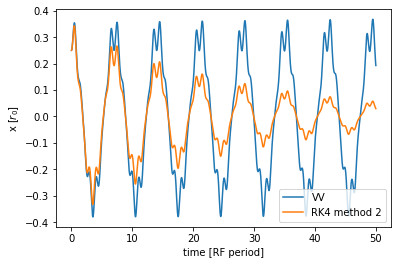

In [44]:
plt.figure('Ion algorithm',clear='True')
ax = plt.subplot(111)

ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt),v_vv,color='g',ls='--',label='VV')
# ax.plot(t_vv/(100*dt),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,label='RK4 method 2')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,label='RK4')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()

## Other references
https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html

http://spiff.rit.edu/richmond/nbody/OrbitRungeKutta4.pdf

https://physics.stackexchange.com/search?q=runge+kutta+4

# Loading data from Fortran version
```gfortran -o3 .\Runge_Kutta_ions.f90 -o a.exe; .\a.exe```

In [159]:
with open('K:\\Universite_Simus\\20220215\\xva.dat') as f:
    t_For,r_For,v_For,a_For = np.loadtxt(f,unpack=True)

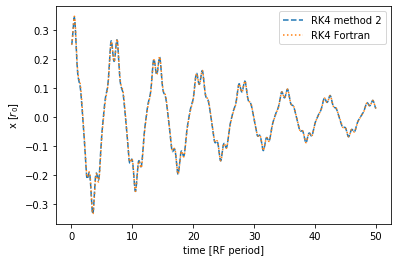

In [163]:
plt.figure('Pendulum algorithm',clear='True')
ax = plt.subplot(111)

# ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt_vv),v_vv,color='g',label='VV')
# ax.plot(t_vv/(100*dt_vv),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,ls='--',label='RK4 method 2')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,ls='--',label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,ls='--',label='RK4')

ax.plot(t_For/(nt*dt_rk4),np.array(r_For)/r0,ls=':',label='RK4 Fortran')
# ax.plot(t_For/(nt*dt_rk4),v_For,ls=':',label='RK4 Fortran')
# ax.plot(t_For/(nt*dt_rk4),a_For,ls=':',label='RK4 Fortran')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()